In [15]:
from google.colab import files, drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
!ls -l donkey

lrwxrwxrwx 1 root root 31 Oct 16 11:29 donkey -> '/content/gdrive/My Drive/donkey'


In [0]:
# Importy Pythonowe

import json
import os
import zipfile
import glob

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from tqdm import tqdm

import seaborn as sns
sns.set_style('whitegrid')

import keras as K
import keras.layers as KL

import IPython.display
from IPython.display import HTML

In [5]:
# Czytanie danych do pamięci
records = []
for archive_f in ['donkey/record2.zip', 'donkey/record3.zip']:
  with zipfile.ZipFile(archive_f) as archive:
    for fileinfo in tqdm(archive.filelist):
      filename = fileinfo.filename
      if not filename.endswith('.json') or filename.endswith('meta.json'):
        continue
      with archive.open(filename) as f:
        data = json.load(f)
      basename = os.path.basename(filename)
      dirname = os.path.dirname(filename)
      # ucinamy 'record_' z przodu i '.json' z tylu
      step_number = int(basename[7:-5])
      with archive.open(
          os.path.join(dirname, data['image_array'])) as image_file:
        image = ndimage.imread(image_file) / 255.0
      records.append((step_number, image, data['user_angle'], data['user_throttle']))
records.sort(key=lambda x: x[0])
images = np.array([r[1] for r in records], dtype='float32')
angles = np.array([r[2] for r in records], dtype='float32')[:, None]
throttles = np.array([r[3] for r in records], dtype='float32')[:, None]


100%|██████████| 14178/14178 [00:09<00:00, 1512.44it/s]


In [0]:
images = images[:,2:,:,:]

In [28]:
print('Images to tablica o wymiarach:', images.shape)
print('Angles to tablica o wymiarach:', angles.shape)
print('Throttles to tablica o wymiarach:', throttles.shape)

# Dane (images, angles) podzielimy na 3 podzbiory:
# - dane uczące (train_images, train_angles), na których będziemy trenować modele
# - dane walidacyjne (valid_images, valid_angles) również użyte do treningu modeli
# - dane testowe (test_images, test_angles) na których ocenimy jak dobrze działa
#   nasz model
train_images, valid_images, test_images = np.split(images, [-1000, -500])
train_angles, valid_angles, test_angles = np.split(angles, [-1000, -500])
(train_throttles, valid_throttles, test_throttles
    ) = np.split(throttles, [-1000, -500])

print('Dane uczące mają %d klatek, walidacyjne %d i testowe %d.' % 
      (train_images.shape[0], valid_images.shape[0], test_images.shape[0]))

Images to tablica o wymiarach: (14704, 48, 160, 3)
Angles to tablica o wymiarach: (14704, 1)
Throttles to tablica o wymiarach: (14704, 1)
Dane uczące mają 13704 klatek, walidacyjne 500 i testowe 500.


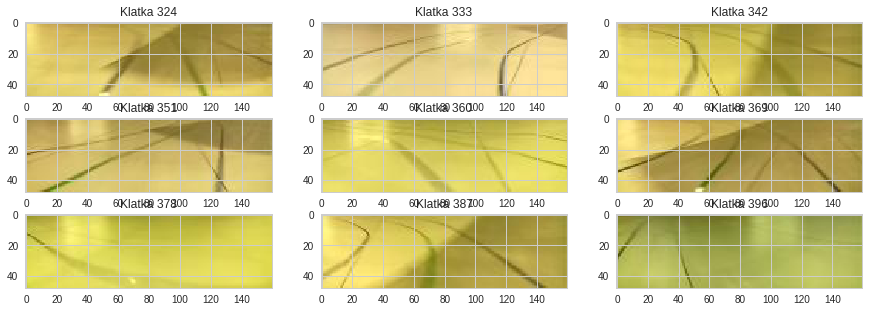

In [53]:
# Wizualizacja danych

k = 4
plt.figure(figsize=(15, 5))
for i, frame in enumerate(range(k*9*9, (k+1)*9*9, 9)):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[frame])
  plt.title("Klatka %d" % (frame,))

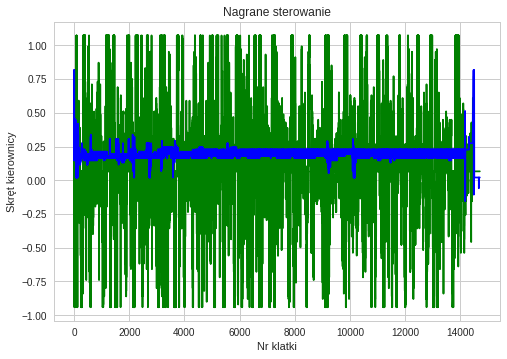

In [30]:
plt.plot(angles, color='g', label='recorded steering')
plt.plot(throttles, color='b', label='recorded steering')
plt.title('Nagrane sterowanie')
plt.xlabel('Nr klatki')
plt.ylabel('Skręt kierownicy')
None

In [0]:
  img_in = KL.Input(shape=(48, 160, 3), name='img_in')
  x = img_in

  # Convolution2D class name is an alias for Conv2D
  x = KL.Convolution2D(filters=24, kernel_size=(5, 5), strides=(1, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=32, kernel_size=(5, 5), strides=(1, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
  x = KL.Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

  x = KL.Flatten(name='flattened')(x)
  x = KL.Dense(units=100, activation='linear')(x)
  x = KL.Dropout(rate=.1)(x)
  x = KL.Dense(units=50, activation='linear')(x)
  x = KL.Dropout(rate=.1)(x)
  # categorical output of the angle
  angle_out = KL.Dense(units=1, activation='linear', name='angle_out')(x)

  # continous output of throttle
  throttle_out = KL.Dense(units=1, activation='linear', name='throttle_out')(x)

  model = K.Model(inputs=[img_in], outputs=[angle_out, throttle_out])

  model.compile(optimizer='adam',
                loss={'angle_out': 'mean_squared_error',
                      'throttle_out': 'mean_squared_error'},
                loss_weights={'angle_out': 0.5, 'throttle_out': 0.5})


In [32]:
callbacks = [
    K.callbacks.ModelCheckpoint('model', save_best_only=True),
    K.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=.0005,
                              patience=5,
                              verbose=True,
                              mode='auto')
]

# Model uczymy na danych uczących.
# Po każdej epoce (ang. epoch) policzymy błąd na danych walidacyjnych i jeśli
# model jest lepszy (błąd jest mniejszy), zapisujemy go.

hist = model.fit(train_images, [train_angles, train_throttles], 
                 epochs=200, 
                 validation_data=(valid_images, [valid_angles, valid_throttles]), 
                 callbacks=callbacks)


Train on 13704 samples, validate on 500 samples
Epoch 1/200
13704/13704 [==============================] - 12s 850us/step - loss: 0.0762 - angle_out_loss: 0.1480 - throttle_out_loss: 0.0044 - val_loss: 0.0533 - val_angle_out_loss: 0.1049 - val_throttle_out_loss: 0.0017
Epoch 2/200
13704/13704 [==============================] - 11s 777us/step - loss: 0.0381 - angle_out_loss: 0.0740 - throttle_out_loss: 0.0021 - val_loss: 0.0351 - val_angle_out_loss: 0.0686 - val_throttle_out_loss: 0.0017
Epoch 3/200
13704/13704 [==============================] - 11s 776us/step - loss: 0.0326 - angle_out_loss: 0.0633 - throttle_out_loss: 0.0019 - val_loss: 0.0376 - val_angle_out_loss: 0.0734 - val_throttle_out_loss: 0.0017
Epoch 4/200
13704/13704 [==============================] - 11s 775us/step - loss: 0.0287 - angle_out_loss: 0.0556 - throttle_out_loss: 0.0018 - val_loss: 0.0309 - val_angle_out_loss: 0.0602 - val_throttle_out_loss: 0.0016
Epoch 5/200
13704/13704 [==============================] - 11s 7

## Analiza wyuczonej sieci
Najpierw sprawdzimy błąd MSE osiągnięty przez sieć.

In [33]:
#@title Wczytywanie najlepszej sieci
best_model = K.models.load_model('model')

print('Obliczony przez Keras błąd walidacyjny:',
      best_model.evaluate(valid_images,
                          [valid_angles, valid_throttles], verbose=0))
print('Obliczony przez Keras błąd testowy:',
      best_model.evaluate(test_images,
                          [test_angles, test_throttles], verbose=0))

Obliczony przez Keras błąd walidacyjny: [0.026776355400681497, 0.0519016754925251, 0.0016510351449251174]
Obliczony przez Keras błąd testowy: [0.026187078207731248, 0.014153884686529637, 0.038220272846519944]


Teraz zobaczymy jak można wykorzystać sieć do przewidywania sterowania na danych testowych:

In [0]:
#@title Użycie najlepszej sieci

# Obliczamy kąty przewidziane przez sieć na danych testowych
pred_test_angles, pred_test_throttles = best_model.predict(test_images)

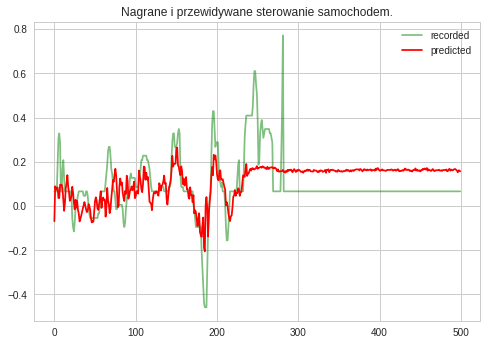

In [35]:
plt.plot(test_angles, label='recorded', color='g', alpha=0.5)
plt.plot(pred_test_angles, label='predicted', color='r')
plt.legend(loc='upper right')
plt.title('Nagrane i przewidywane sterowanie samochodem.')
None

In [0]:
files.download('model')